# Project 2 report

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as statsh
url = 'https://storage.googleapis.com/dft-statistics/road-traffic/downloads/rawcount/region_id/dft_rawcount_region_id_3.csv'
df = pd.read_csv(url)
df_original= df.copy()
print(df.head())

   count_point_id direction_of_travel  year  count_date  hour  region_id  \
0              62                   E  2021  2021-09-15     7          3   
1              62                   E  2021  2021-09-15     8          3   
2              62                   E  2021  2021-09-15     9          3   
3              62                   E  2021  2021-09-15    10          3   
4              62                   E  2021  2021-09-15    11          3   

  region_name  local_authority_id local_authority_name road_name  ...  \
0    Scotland                   4    North Lanarkshire       M80  ...   
1    Scotland                   4    North Lanarkshire       M80  ...   
2    Scotland                   4    North Lanarkshire       M80  ...   
3    Scotland                   4    North Lanarkshire       M80  ...   
4    Scotland                   4    North Lanarkshire       M80  ...   

  buses_and_coaches lgvs hgvs_2_rigid_axle  hgvs_3_rigid_axle  \
0                 1  707               

/tmp/ipykernel_12997/81001452.py:7: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


In [3]:
# Select columns we need
df = df[['count_point_id', 'count_date','year','hour', 'road_name','road_type', 'latitude','longitude','local_authority_name','all_motor_vehicles']]
df_road = df[df['local_authority_name'].isin(['Glasgow City', 'City of Edinburgh'])]

# Summarise data by grouping by count_point_id and count_date
counted_road = (
    df_road
    .groupby(['count_point_id', 'count_date', 'year', 'hour','local_authority_name', 'road_name', 'road_type','latitude','longitude'], as_index=False)
    .agg({'all_motor_vehicles': 'sum'})
)

del counted_road['count_date']

# Setting the year range
all_years = pd.DataFrame({'year': range(2000, 2024)})


# Interpolation by count_point_id (including extrapolation)
expanded_data = []
for count_point_id, group in counted_road.groupby('count_point_id'):
    # Ensure 'group' includes all years
    full_group = (
        pd.merge(all_years, group, on='year', how='left')
        .sort_values('year')  # Sorting for interpolation
    )
    # Interpolate and extrapolate all_motor_vehicles
    full_group['all_motor_vehicles'] = full_group['all_motor_vehicles'].interpolate(method='linear',
                                                                                    limit_direction='both')

    # Fill other columns
    for col in ['count_point_id','hour', 'road_name', 'road_type','latitude','longitude']:
        full_group[col] = full_group[col].ffill().bfill()

    expanded_data.append(full_group)

# Merge all results
result = pd.concat(expanded_data, ignore_index=True)

# Amendments to data types
result['count_point_id'] = result['count_point_id'].astype(int)
result['all_motor_vehicles'] = result['all_motor_vehicles'].astype(int)


# Selecting data for years 2006-2017
processed_road_vehicles = result[result['year'].isin([2006,2007,2008,2009,2010,2011,
                                                      2012,2013,2014,2015,2016,2017])]

(processed_road_vehicles)



,year,count_point_id,hour,local_authority_name,road_name,road_type,latitude,longitude,all_motor_vehicles
17,2006,703,7.0,City of Edinburgh,M9,Major,55.961704,-3.412781,2029
18,2006,703,8.0,City of Edinburgh,M9,Major,55.961704,-3.412781,2254
19,2006,703,9.0,City of Edinburgh,M9,Major,55.961704,-3.412781,1879
20,2006,703,10.0,City of Edinburgh,M9,Major,55.961704,-3.412781,1750
21,2006,703,11.0,City of Edinburgh,M9,Major,55.961704,-3.412781,1794
...,...,...,...,...,...,...,...,...,...
26091,2015,996338,16.0,City of Edinburgh,C,Minor,55.950476,-3.177343,664
26092,2015,996338,17.0,City of Edinburgh,C,Minor,55.950476,-3.177343,728
26093,2015,996338,18.0,City of Edinburgh,C,Minor,55.950476,-3.177343,613
26094,2016,996338,18.0,NaN,C,Minor,55.950476,-3.177343,593


# Graph 1: Distribution of Annual Average Daily Traffic Flow

## Overview 
The first graph shows the distribution of annual average daily traffic flow for two cities: Edinburgh and Glasgow.
It shows the traffic trends across four road categories from 2006 to 2017.
The four road categories represented in the plot are:
- **Edinburgh Major Roads**
- **Edinburgh Minor Roads**
- **Glasgow Major Roads**
- **Glasgow Minor Roads**

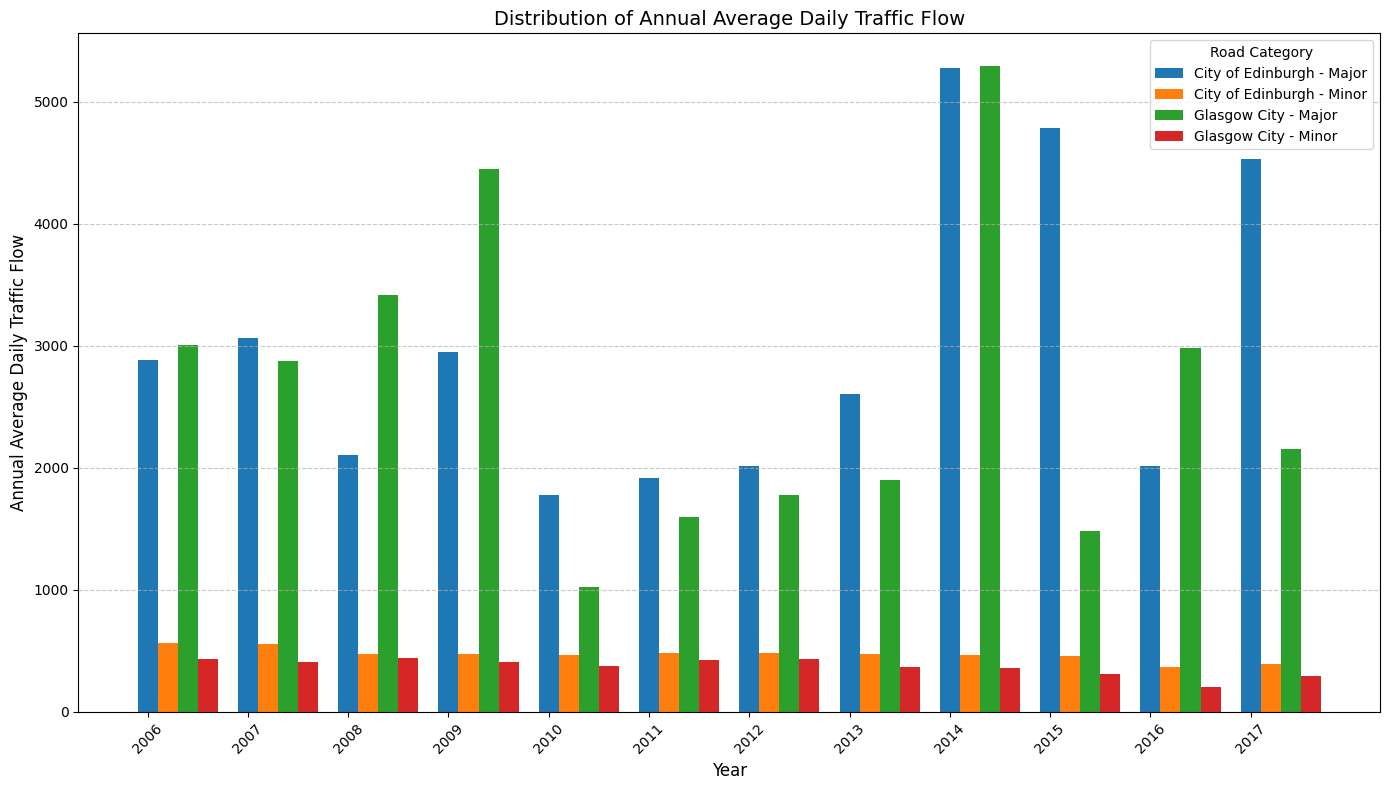

In [4]:
# Grouping the processed road vehicles data by 'year', 'local_authority_name', and 'road_type',
# and calculating the mean value of 'all_motor_vehicles' to get the annual average daily traffic
annual_traffic_flow = (
    processed_road_vehicles
    .groupby(['year', 'local_authority_name', 'road_type'], as_index=False)
    .agg({'all_motor_vehicles': 'mean'}) 
    .rename(columns={'all_motor_vehicles': 'avg_daily_traffic'})
)

# Set the width for the bars in the bar chart
bar_width = 0.2

# Sorting years to ensure the chart has a consistent order
years = sorted(annual_traffic_flow['year'].unique())

# Extracting the unique road types 
road_types = annual_traffic_flow['road_type'].unique()

# Specifying the cities
cities = ['City of Edinburgh', 'Glasgow City']

# Create a figure & Generating x positions for the years on the x-axis
plt.figure(figsize=(14, 8))
x = range(len(years))

# Loop through each city and its respective road types to plot the data
for city_idx, city in enumerate(cities):
    for road_idx, road_type in enumerate(road_types):
        # Filter the data for the current city and road type
        subset = annual_traffic_flow[
            (annual_traffic_flow['local_authority_name'] == city) &
            (annual_traffic_flow['road_type'] == road_type)
        ]

        # For each year, extract the average daily traffic for that city and road type, or assign 0 if data is missing
        y_values = [subset[subset['year'] == year]['avg_daily_traffic'].values[0] 
                    if year in subset['year'].values else 0 for year in years]
        # Plot the bar for the current combination of city, road type, and year
        plt.bar(
            [pos + city_idx * len(road_types) * bar_width + road_idx * bar_width for pos in x],
            y_values, # Height of the bar (the average daily traffic values)
            bar_width, # Width of the bar
            label=f"{city} - {road_type}" # Label for the legend (city and road type)
        )
# Title of the plot & Label for the x-axis/y-axis
plt.title('Distribution of Annual Average Daily Traffic Flow', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Annual Average Daily Traffic Flow', fontsize=12)

# Set x-axis ticks to be the years and rotate the labels
plt.xticks(np.arange(len(years)),[str(year) for year in years], rotation=45)

# Add a legend with the title 'Road Category' and set the font size
plt.legend(title='Road Category', fontsize=10)

# Add a grid to the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the layout to make the plot fit well within the figure
plt.tight_layout()

# Display the plot
plt.show()


## Investigation and Explanation:
The years are segmented into three distinct phases based on the oil price dynamics:
1. **Pre-Oil Price Reduction (2006-2009)**
2. **Oil Price Reduction (2010-2013)**
3. **Oil Price Recovery (2013-2017)**

- **Minor Roads**: The traffic on minor roads in both Edinburgh and Glasgow remained relatively stable every year, consistently staying below 10,000 vehciles annually, with a typical range between 7,000 to 8,000. This suggests that minor roads experience less fluctuation in traffic and the oil price changes dis not significantly impact these roads.
- **Major Roads**:
    - **Edinburgh**: Traffic peaked in 2014, with over 60,000 vehcile per day. This marked the highest value in the period under analysis. The traffic showed a minimum in 2010, with just over 20,000 vehicles, aligning with the oil price reduction phase. 
    - **Glasgow**: Similarly, Glasgow saw a peak in 2014, with traffic surpassing 60,000 vehciles, matching the trend observed in Edinburgh.

## Graph Description:
- **X-axis**: Represents the years from 2016-2017.
- **Y-axis**: Represents the average daily traffic for each road category.
- **Bars**: The bars represent the traffic volumes, with different bar colors representing the four road categories.
    - The first set of bars represents Edinburgh's major roads.
    - The second set represents Edinburgh's minor roads.
    - The third set represents Glasgow's major roads.
    - The fourth set represents Glasgow's minor roads. 

## Conclusion:
This graph highlights the impact of oil price fluctuations on traffic trends in Edinburgh and Glasgow. Minor road showed minimal change, while traffic on major roads in both cities was heavily influenced by the oil price reduction and recovery phases. 

# Graph 2: Traffic Volume Trends in Edinburgh and Glasgow (2006-2017)

## Overview
The graph below shows the traffic volume trends for Edinburgh and Glasgow between 2006 and 2017. 
It shows the total number of motot vehicles recorded each year for both cities.
The analysis reveals significant fluctuations in traffic volume, with notable peaks and drops that correspond to broader economic events and changes in transportation behaviour.

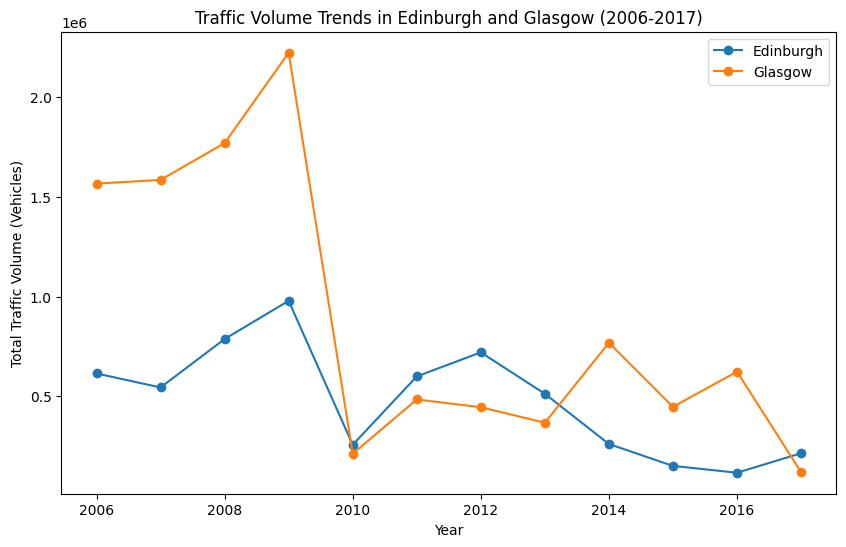

In [5]:
# Filter the data to include only rows where the local authority is Edinburgh & Glasgow
edinburgh = processed_road_vehicles[processed_road_vehicles['local_authority_name'] == 'City of Edinburgh']
glasgow = processed_road_vehicles[processed_road_vehicles['local_authority_name'] == 'Glasgow City']

# Group the data by 'year' and calculate the total sum of 'all_motor_vehicles' for each year
edinburgh_traffic = edinburgh.groupby('year')['all_motor_vehicles'].sum().reset_index()
glasgow_traffic = glasgow.groupby('year')['all_motor_vehicles'].sum().reset_index()

# Create a new figure for the plot
plt.figure(figsize=(10, 6))

# Plot the total traffic volume for Edinburgh & Glasgow, with years on the x-axis and traffic volume on the y-axis
# Use a line with circular markers ('o') to represent the data points for each year
plt.plot(edinburgh_traffic['year'], edinburgh_traffic['all_motor_vehicles'], label='Edinburgh', marker='o')
plt.plot(glasgow_traffic['year'], glasgow_traffic['all_motor_vehicles'], label='Glasgow', marker='o')

# Set the label for the x-axis & y-axis
plt.xlabel('Year')
plt.ylabel('Total Traffic Volume (Vehicles)')

# Set the title of the plot
plt.title('Traffic Volume Trends in Edinburgh and Glasgow (2006-2017)')

# Display the legend to differentiate between the two cities (Edinburgh and Glasgow)
plt.legend()

# Investigation and Explanation:
The investigation examines the traffic volume patterns in Edinburgh and Glasgow from 2006 to 2017, focusing on the overall trends, peak years and significant fluctuations.
- **2006 to 2009 Increase**: Both cities experienced a steady increase in traffic volume leading up to 2009. Glasgow's traffic volume started at over 1.5 million vehicles, while Edinburgh's traffic was over 500,000. By 2009, both cities reached their peak traffic volumes: Glasgow exceeded 2 million vehciles, and Edinburgh reached 1 million. This increase was likely driven by economic growth and greater vehicle usage during this period
- **2010 Drop**: In 2010, both cities saw a significant decline in traffic volume. Edinburgh and Glasgow's traffic dropped sharply to around 250,000 vehicles each, representing a considerable decrease from the previous year. This sudden drop is likely linked to the impact of global financial crisis and expectation of the forthcoming oil price reduction. It led to reduced travel and lower vehicle usage during this period.
- **Post-2010 Fluctuations**: After the sharp decline in 2010, traffic volumes fluctuated for both cities. Neither city showed a clear upward or downward trend, suggesting a mix of economic recovery, changes in fuel prices and shifting transportation patterns.
- **2016 and 2017 Minimums**: The lowest traffic volumes for both cities were recorded in 2016 for Edinburgh (100,000 vehicles) and in 2017 for Glasgow (also around 100,000 vehicles) The nearly identical minimums suggest that external factors, such as national economic conditions or transportation infrastructure changes. might have affected both cities in similar ways, leading to comparable reduction in traffic volume. 

# Conclusion of Graph 2:
The traffic volume trends in Edinburgh and Glasgow reveal the significant impact of broader economic events, particularly the global financial crisis, oil price fluctuations and Brexit

# Graph 3: Annual Average Percentage of Traffic by Hour (Grouped by Period)
## Overview
The radial graph below visualizes the annual average percentage of traffic by hours, grouped into distinct periods. The graph uses a polar coordinate system with a **clock-style layout**.

This graph aids in identifying shifts in traffic behaviour over time and understand how external factors, such as oil price changes, may influence traffic patterns. 
The grouped approach allows for easy comparison between periods.

/tmp/ipykernel_12997/2991349084.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_road_vehicles['dailyhourtotal'] = processed_road_vehicles.groupby(['count_point_id', 'hour'])['all_motor_vehicles'].transform('sum')
/tmp/ipykernel_12997/2991349084.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_result_graph3['dailytotalvehicles'] = final_result_graph3.groupby('count_point_id')['dailyhourtotal'].transform('sum')
/tmp/ipykernel_12997/2991349084.py:18: SettingWithCopyWarning: 
A value is 

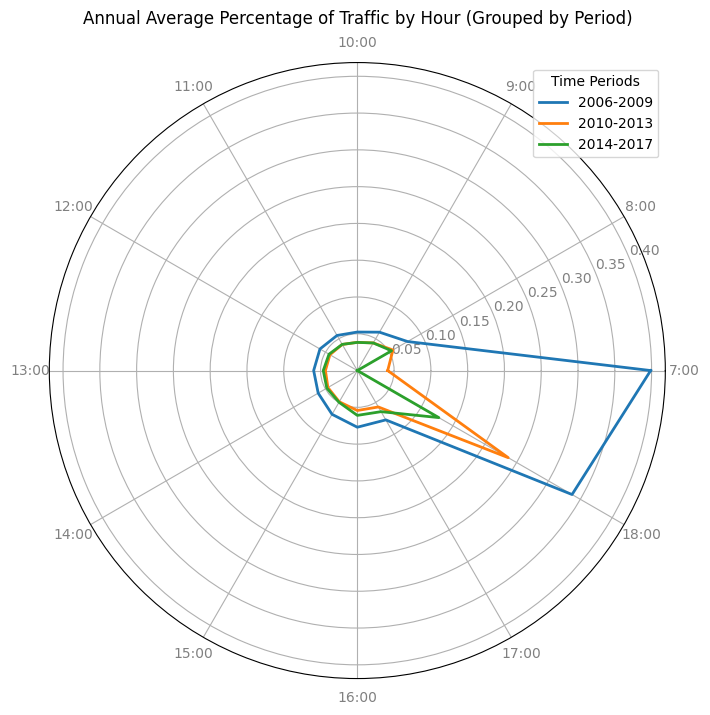

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import pandas as pd

# Group count_id and hour, and calculate the dailyhourtotal
processed_road_vehicles['dailyhourtotal'] = processed_road_vehicles.groupby(['count_point_id', 'hour'])['all_motor_vehicles'].transform('sum')

# Remove duplicates (because 'hour == 7-18' occurs multiple times in different 'count_point_id')
final_result_graph3 = processed_road_vehicles.drop_duplicates(subset=['count_point_id', 'hour'])

# Step 1: Calculate the dailytotalvehicles for each count_id
# The 'dailytotalvehicles' is calculated by grouping the data by 'count_point_id' and summing the 'dailyhourtotal' for each group.
final_result_graph3['dailytotalvehicles'] = final_result_graph3.groupby('count_point_id')['dailyhourtotal'].transform('sum')

# Step 2: Calculate dailyhour%
# The 'dailyhour%' is calculated by dividing the 'dailyhourtotal' by the 'dailytotalvehicles' for each record and multiplying by 100 to get the percentage.
final_result_graph3['dailyhour%'] = final_result_graph3['dailyhourtotal'] / final_result_graph3['dailytotalvehicles'] * 100

# Handle NaN or 0 values to prevent dividing by 0
final_result_graph3['dailyhour%'] = final_result_graph3.apply(lambda row: row['dailyhourtotal'] / row['dailytotalvehicles'] if row['dailytotalvehicles'] != 0 else 0, axis=1)

# Define hour range
hours_range = list(range(7, 19)) # 7 AM to 6 PM

# Extraction year grouping
periods = {
"2006-2009": final_result_graph3[final_result_graph3['year'].between(2006, 2009)],
"2010-2013": final_result_graph3[final_result_graph3['year'].between(2010, 2013)],
"2014-2017": final_result_graph3[final_result_graph3['year'].between(2014, 2017)],
}

# Group by hour, calculate the average of dailyhour%, and ensure that the result is available every hour
# This calculates the average percentage of traffic for each hour for each period.
averages = {}
for period, data in periods.items():
    avg = data.groupby('hour')['dailyhour%'].mean() # Group by hour and calculate the average 'dailyhour%'
    avg = avg.reindex(hours_range, fill_value=0) # Reindex to ensure all hours are represented (from 7 AM to 6 PM)
    averages[period] = avg.tolist()  # Store the average values for each period

# Radar chart setup
hours = np.arange(7, 19)  # 7 AM to 6 PM
categories = [f"{hour}:00" for hour in hours]

# Convert the categories into angles for the radar chart
# The angle for each category is calculated by dividing the full circle (2*pi) by the number of categories (12 hours in this case)
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]  # Close the circle

# Plot radar chart
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Define colors for each period
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, orange, green

# Plot the radar chart for each period
# For each period, the 'values' are the list of average daily percentages for each hour.
# The first value is repeated at the end of the list to close the circle in the radar chart.
for i, (period, averages) in enumerate(averages.items()):
    values = list(averages) + [averages[0]]  # Close the circle
    ax.plot(angles, values, linewidth=2, linestyle="solid", label=period, color=colors[i])


# Configure the chart
plt.xticks(angles[:-1], categories, color="gray", fontsize=10)
plt.yticks(color="gray")
plt.title("Annual Average Percentage of Traffic by Hour (Grouped by Period)", va="bottom")
plt.legend(loc="upper right", title="Time Periods")

plt.show()

## Investigation and Explanation:
The radar chart analyses traffic flow patterns grouped into three distinct time periods:
1. **2006–2009**: Early traffic trends in the dataset, serving as a baseline for comparison.
2. **2010–2013**: Midpoint data to observe shifts or consistencies in traffic patterns.
3. **2014–2017**: Recent traffic trends reflecting potential developments in urban dynamics.

### Key Observations:
- **Morning Peaks (7 AM–9 AM)**:
  - In the period of 2006-2009, the morning peak was still concentrated at 7am, but from 2010, the morning peak gradually moved to 8am.

- **Midday Traffic (12 PM–2 PM)**:
  - There is not much difference between the three stages in this period, and the changes in each period are relatively gentle, which belongs to the stage with small traffic flow throughout the day

- **Evening Peaks (4 PM–6 PM)**:
  -There is not much change in the three stages of the evening peak, which are all concentrated at 6 p.m., with a sudden increase in traffic
  
## Graph Description:
- **X-axis (Angles)**: Represents hours of the day from 7:00 AM to 6:00 PM.
- **Y-axis (Radial Distance)**: Indicates the percentage of daily traffic allocated to each hour.
- **Lines**: 
  - Each line corresponds to one of the three time periods.
  - Distinct colours are used to differentiate between the periods (blue for 2006–2009, orange for 2010–2013, and green for 2014–2017).

## Conclusion:
Our analysis reveals that during periods of rising fuel prices, there is a shift in travel behavior, particularly in peak travel times. Specifically, the morning rush hour, traditionally concentrated at 7 AM, moved to 8 AM as people adjusted their schedules to **reduce fuel consumption during peak travel times**. However, the evening rush hour remained concentrated around 6 PM, indicating that evening travel patterns were less sensitive to fuel price changes. Additionally, when fuel prices began to stabilize, the morning peak did not revert back to 7 AM, suggesting that the shift in travel behavior may have become ingrained or people adjusted their routines in ways that were not directly related to fuel prices. This highlights the lasting impact of fuel price fluctuations on travel behavior and the potential for **long-term changes in commuting patterns**.


# Graph4. Vehicle Type Percentage Distribution Over Years (2006-2017)
## Overview
Using vehicle type data, we analyze the impact of oil price fluctuations on the traffic flow of different types of vehicles.

Both the **Circular Stacked Chart** and the **Line Chart** indicate the proportion of each type of traffic flow to the total traffic from 2006 to 2017

In the Circular Stacked Chart, each year corresponds to a ring bar, the color represents different vehicle types, and the width of each ring represents the proportion of the type, so it can be more intuitive to see which vehicle proportion increases or decreases. The line chart provides us with data in more detail.

In [7]:
# Step 1: Filter the original DataFrame for data related to 'City of Edinburgh' and 'Glasgow City'
filter_df =  df_original.loc[(df_original['local_authority_name'] == 'City of Edinburgh') | (df_original['local_authority_name'] == 'Glasgow City')]

# Step 2: Group the filtered DataFrame by 'year' and calculate the sum for each year
group_df_Graph4 = filter_df.groupby('year').sum()

# Step 3: Select the years from 2006 to 2017 and specific vehicle types for further analysis
group_df_Graph4 = group_df_Graph4.loc[2006:2017,['two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'all_hgvs','all_motor_vehicles']]

# Reset the index to turn year into a regular column
group_df_Graph4 = group_df_Graph4.reset_index()

# Create a new DataFrame that contains percentage data
group_final_Graph4 = group_df_Graph4[['year']].copy()

# Get all vehicle type columns (remove 'year' and 'all_motor_vehicles')
vehicle_columns = ['two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'all_hgvs']

# The proportion is calculated for each vehicle type
for vehicle in vehicle_columns:
    group_final_Graph4[f'{vehicle}%'] = group_df_Graph4[vehicle] / group_df_Graph4['all_motor_vehicles']

group_final_Graph4


,year,two_wheeled_motor_vehicles%,cars_and_taxis%,buses_and_coaches%,lgvs%,all_hgvs%
0,2006,0.003915,0.778161,0.015958,0.129580,0.072385
1,2007,0.004223,0.773247,0.017350,0.132663,0.072516
2,2008,0.004667,0.775064,0.016954,0.134008,0.069308
3,2009,0.004906,0.793715,0.012738,0.127386,0.061255
4,2010,0.005435,0.826938,0.028174,0.107906,0.031547
5,2011,0.005133,0.823169,0.024326,0.113327,0.034045
6,2012,0.005081,0.826830,0.018315,0.121347,0.028427
7,2013,0.004746,0.834253,0.020515,0.115259,0.025227
8,2014,0.003703,0.795819,0.011544,0.143068,0.045866
9,2015,0.003666,0.806217,0.014942,0.134084,0.041091


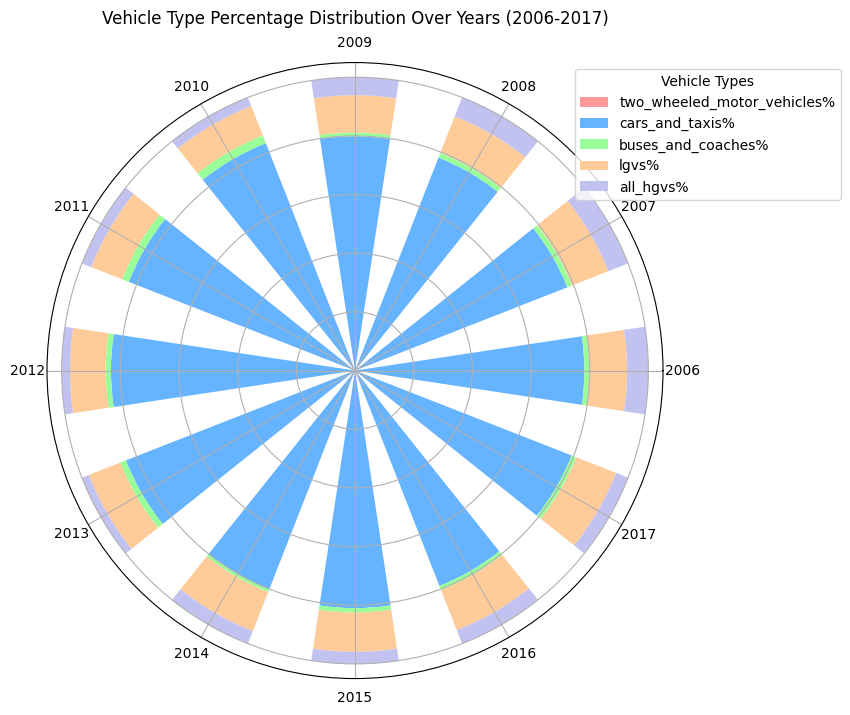

In [8]:
# Reimport necessary libraries due to environment reset
import matplotlib.pyplot as plt
import numpy as np

# Data Preparation 
# Convert 'year' column to string format and convert it to a list
years = group_final_Graph4['year'].astype(str).tolist()  

# Define the list of vehicle types for which we have percentage data
vehicle_types = ['two_wheeled_motor_vehicles%', 'cars_and_taxis%', 'buses_and_coaches%', 'lgvs%', 'all_hgvs%']

# Extract the percentage data for each vehicle type across all years
data = group_final_Graph4[vehicle_types].values  

# # Color settings
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

#  Create a  plot for the circular stacked bar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Calculate the angles for each year to distribute the bars evenly around the circle
angles = np.linspace(0, 2 * np.pi, len(years), endpoint=False).tolist()

# Loop over each vehicle type and plot the stacked bar for each
for i, vehicle_type in enumerate(vehicle_types):
    ax.bar(
        angles, 
        data[:, i], # The height of each bar (percentage data for this vehicle type)
        width=0.3,  # The width of each bar
        bottom=np.sum(data[:, :i], axis=1),  # Stack previous vehicle types' values
        color=colors[i], 
        label=vehicle_type
    )

# Configure the chart's appearance
ax.set_yticklabels([])  # # Remove radial (y-axis) labels
ax.set_xticks(angles)
ax.set_xticklabels(years)

# Add a legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), title="Vehicle Types")

# Add a title
plt.title('Vehicle Type Percentage Distribution Over Years (2006-2017)', va='bottom')


plt.show()

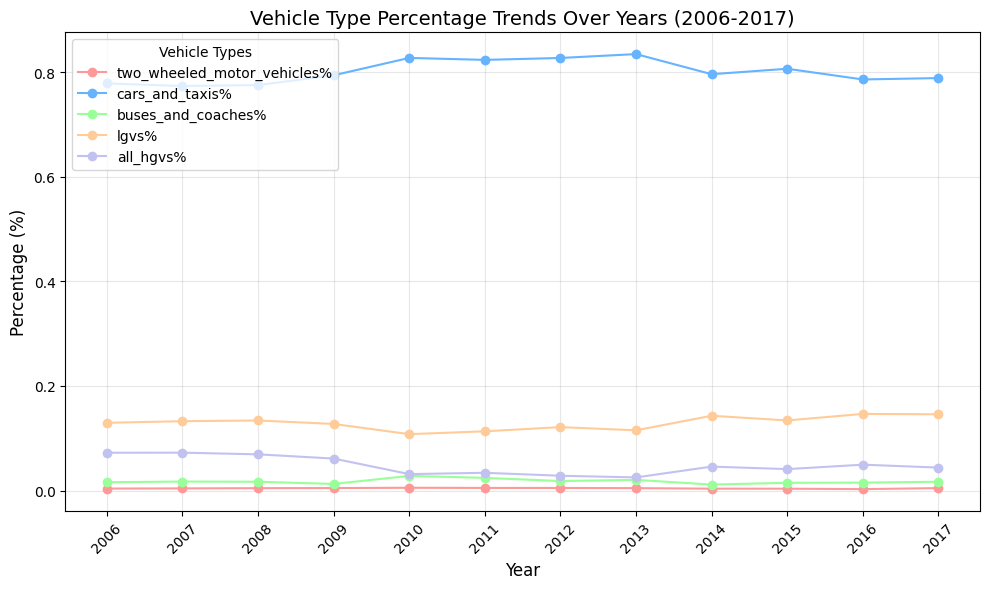

In [9]:
import matplotlib.pyplot as plt

# Data Preparation
years = group_final_Graph4['year']  # year
vehicle_types = ['two_wheeled_motor_vehicles%', 'cars_and_taxis%', 'buses_and_coaches%', 'lgvs%', 'all_hgvs%']
data = group_final_Graph4[vehicle_types]  # percentage

# color setting
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

# Create a  plot 
plt.figure(figsize=(10, 6))

# # Loop through each vehicle type and plot its trend over the years
for i, vehicle_type in enumerate(vehicle_types):
    plt.plot(years, data[vehicle_type], marker='o', label=vehicle_type, color=colors[i])

# # Add chart elements such as the title, labels for the x and y axes, and grid
plt.title('Vehicle Type Percentage Trends Over Years (2006-2017)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(years, rotation=45)  #  # Set years as the tick labels on the x-axis
plt.grid(alpha=0.3)
plt.legend(title="Vehicle Types", loc='upper left')

# Adjust the layout to avoid overlap of elements and ensure everything fits well within the figure
plt.tight_layout()
plt.show()


### Investigation and Explanation:
Both the **Circular Stacked Chart** and the **Line chart** clearly show that the proportion of vehicle types changed in **2010**, and gradually recovered to the proportion before 2010 from **2013**

### Key Observations:
- **'Two wheeled motor vehicles',' Cars and Taxis', and 'Buses and Coaches' are the three vehicle types that show an upward trend during the oil price rise**:
  - The two types of vehicles, cars and taxis, and buses and coaches, have increased significantly, while the two wheeled motor vehicles have increased slightly.

- **The two vehicle types' Lgvs' and 'Hgvs' showed a downward trend during the period of rising oil prices**:
  - 'Hgvs' declines more than' Lgvs'.


### Circular Stacked Chart - Graph Description:
- **X-axis (Angles)**: Represents the years from 2006 to 2017, evenly distributed along the circular axis.
- **Y-axis (Radial Distance)**: Indicates the cumulative percentage of all motor vehicle types (two-wheeled motor vehicles, cars and taxis, buses and coaches, LGVs, and all HGVs).
- **Bars**: 
  - Each bar segment represents the percentage contribution of a specific vehicle type to the total motor vehicles for that year.
  - Distinct colours are used to differentiate between the vehicle types:
    - Red: Two-Wheeled Motor Vehicles  
    - Blue: Cars and Taxis  
    - Green: Buses and Coaches  
    - Orange: LGVs  
    - Purple: All HGVs  

### Line Chart - Graph Description:
- **X-axis (Years)**: Represents the years from 2006 to 2017, arranged chronologically.
- **Y-axis (Percentage)**: Indicates the percentage contribution of each motor vehicle type to the total number of motor vehicles.
- **Lines**: 
  - Each line corresponds to a specific vehicle type, showing its percentage trend over time.
  - Distinct colours are used to differentiate between the vehicle types:
    - Red: Two-Wheeled Motor Vehicles  
    - Blue: Cars and Taxis  
    - Green: Buses and Coaches  
    - Orange: LGVs  
    - Purple: All HGVs  
  - Data points are marked along the lines to highlight exact percentages for each year.

### Conclusion
The observed trends suggest that rising fuel prices significantly influence transportation patterns. The decline in **LGVs** and **HGVs** likely reflects the higher operational costs associated with these vehicles, prompting businesses to scale back or optimize logistics. Conversely, the increase in **Cars and Taxis**, **Buses and Coaches**, and **Two-Wheeled Motor Vehicles** indicates a shift towards smaller or shared transportation modes, driven by the need for cost-effective alternatives. This highlights the broader impact of fuel price increases on vehicle usage, encouraging a move away from fuel-intensive options and towards more economical or collective transport solutions.